#### Competition: https://www.kaggle.com/c/demand-forecasting-kernels-only

### Load the training data from csv

In [1]:
# The code was removed by Watson Studio for sharing.

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
print("Number of training rows: {0}".format(df_train.size))

Number of training rows: 3652000


## ETL

### [ETL] Set the correct type for `date`

In [4]:
df_train.dtypes

date     object
store     int64
item      int64
sales     int64
dtype: object

In [5]:
df_train['date'] = pd.to_datetime(df_train['date'])
df_train.dtypes

date     datetime64[ns]
store             int64
item              int64
sales             int64
dtype: object

### [ETL] Create new features from the `date`

In [6]:
df_train['year'] = df_train['date'].dt.year
df_train['month'] = df_train['date'].dt.month
df_train['year-month'] = df_train['date'].dt.to_period('M')
df_train['day-of-month'] = df_train['date'].dt.day
df_train['day-of-week'] = df_train['date'].dt.dayofweek
df_train['day-of-year'] = df_train['date'].dt.dayofyear

In [7]:
df_train.set_index('date', inplace=True)
df_train.sort_index(inplace=True)
df_train.index.name = 'date'

## Data exploration

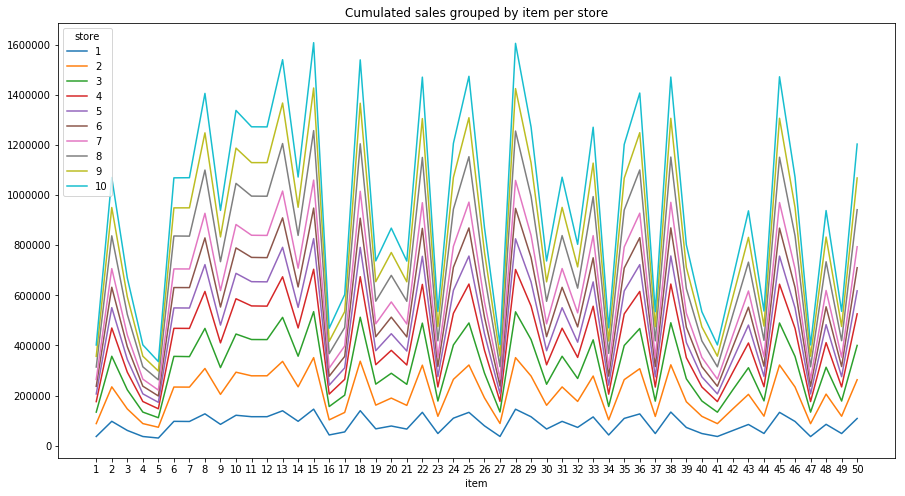

In [8]:
x = df_train.groupby(
    ['store', 'item']
).sum()

x = x.sort_values('sales').reset_index()

x.pivot(
    index='item',
    columns='store',
).plot(
    kind='line',
    stacked=True,
    figsize=[15, 8],
    title='Cumulated sales grouped by item per store',
    xticks=range(1, 51),
    y='sales',
    linestyle='solid'
)


### Observation

- We have 50 items and 10 stores.
- The data looks artificial:

 - all the stores follow the same pattern of sales per item
 - taking any two stores, if store X sells more of item 1 than store Y, the rule remains true for any other item.
     - Eg: store 1 does not have a single item that sells better than store 2

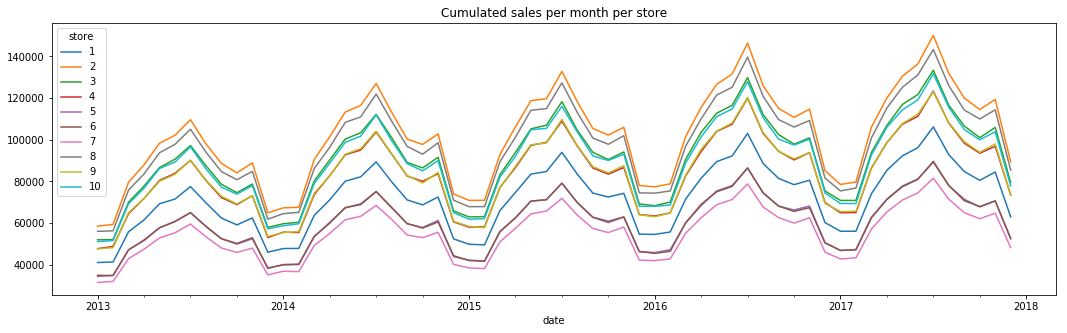

In [9]:
df_train[
    ['store', 'sales']
].groupby(['store']).resample('M')['sales'].sum().unstack('store').plot(
    figsize=(18, 5),
    title="Cumulated sales per month per store",
)

### Observation

We have indeed 5 years of data and we can observe a pattern repeating 5 times (for each year).

It looks like the sales have increased from year to year and follow the same pattern.

Again, this also looks artificial.

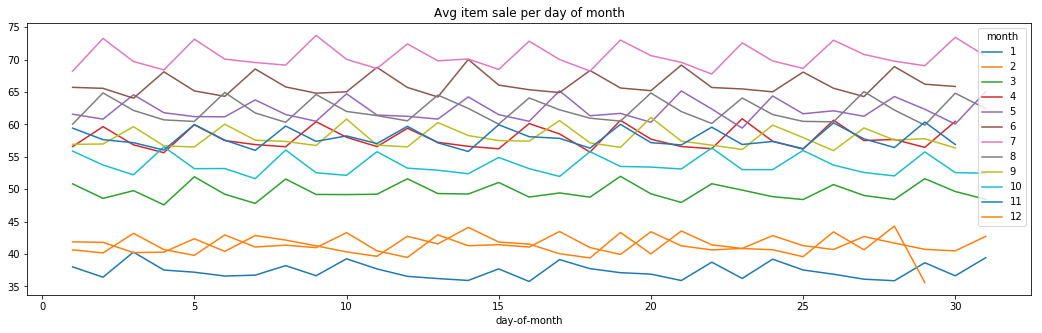

In [10]:
store = 4
# df_train[
    #['store', 'month', 'day-of-month', 'sales']
df_train.groupby(
    ['store', 'month', 'day-of-month']
).mean().unstack('month').loc[store, :]['sales'].plot(figsize=(18, 5), title="Avg item sale per day of month")

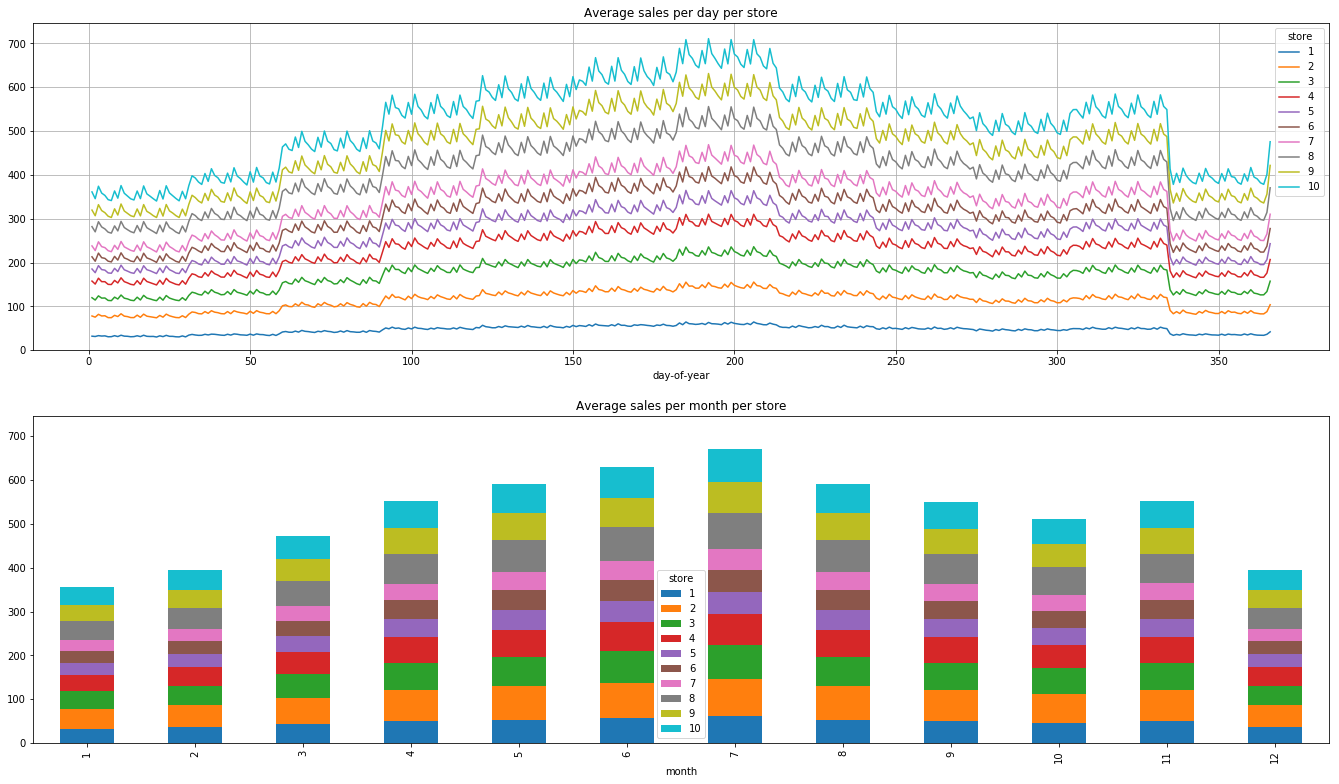

In [11]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharey=True, figsize=(18, 10))

df_day_avg = df_train[
    ['day-of-year', 'store', 'sales']
].groupby(
    ['day-of-year', 'store']
).mean().reset_index().pivot(
    index='day-of-year',
    columns='store'
)

df_day_avg.plot(
    ax=ax1,
    kind='line',
    stacked=True,
    # figsize=(18, 5),
    title="Average sales per day per store",
    legend='store',
    y='sales',
    grid=True
)

df_month_avg = df_train[
    ['month', 'store', 'sales']
].groupby(
    ['month', 'store']
).mean().reset_index().pivot(
    index='month', columns='store'
)

df_month_avg.plot(
    ax=ax2,
    kind='bar',
    stacked=True,
    # figsize=(18, 5),
    title="Average sales per month per store",
    legend='store',
    y='sales'
)
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0.2)

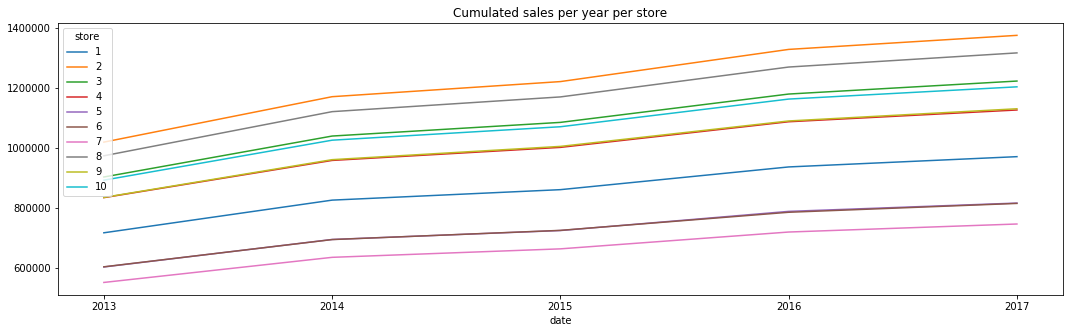

In [12]:
df_train[
    ['store', 'sales']
].groupby(['store']).resample('Y')['sales'].sum().unstack('store').plot(
    figsize=(18, 5),
    title="Cumulated sales per year per store",
)

### Observation

We can see clearer here how the sales have increased from year to year for all stores.

In [13]:
# Find min and max sales month per store

pd.concat([df_month_avg['sales'].idxmax(), df_month_avg['sales'].idxmin()], axis=1, keys=['max', 'min']).T

store,1,2,3,4,5,6,7,8,9,10
max,7,7,7,7,7,7,7,7,7,7
min,1,1,1,1,1,1,1,1,1,1


### Observation

The months can be clearly observed in the first diagram. The second diagram displays the average per month.

The peak sales occure in July (7) and the low occures in January (1). For all the stores

### [ETL] Saving the data to object store

In [14]:
# The code was removed by Watson Studio for sharing.

In [16]:
project.save_data('adsc.etl.csv.1.csv', df_train.to_csv(), overwrite=True)

{'asset_id': '3e04a898-cc6f-42c5-a71f-958f0823a8e8',
 'bucket_name': 'adsc-donotdelete-pr-3deup6emhxg0if',
 'file_name': 'adsc.etl.csv.1.csv',
 'message': 'File adsc.etl.csv.1.csv has been written successfully to the associated OS'}